In [1]:
import pandas

In [2]:
def get_signal(subject_id, run, mask):
    subject_id = '%02d' % int(subject_id)
    run = '%02d' % int(run)    
    run0 = int(run) - 1
    
    signal = np.loadtxt('/home/gdholla1/projects/bias/data/derivatives/extracted_signal/highpassed_motion/_mask_{mask}_subject_id_{subject_id}/_extracter_highpassed_motion{run0}/sub-{subject_id}_task-randomdotmotion_run-{run}_bold_unwarped_st_dtype_mcf_mask_gms_tempfilt_regfilt_maths_ts.txt'.format(**locals()))
    
    signal = (signal / signal.mean()) * 100
    signal -= signal.mean()
    
    return signal

def get_onsets(subject_id, run, design='model0', shift=0):

    df = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior.pandas')
    df = df[(df.subj_idx == subject_id) & (df.block == run)]

    df['onset_cue'] += shift
    df['onset_stim'] += shift
    
    
    if design == 'model0':
        onsets_cue = df.onset_cue.tolist()
        onsets_stim = df.onset_stim.tolist()

        conditions=['onsets_cue',
                    'onsets_stim',]
        
        onsets=[onsets_cue,
                onsets_stim]
        
    elif design == 'model1a':
        conditions=['payoff_cue',
                    'neutral_cue',
                    'difficult_rdm',
                    'easy_rdm']
        
        onsets=[df[df.cue != 'neutral'].onset_cue.tolist(),
                df[df.cue == 'neutral'].onset_cue.tolist(),
                df[df.difficulty == 'easy'].onset_stim.tolist(),
                df[df.difficulty == 'hard'].onset_stim.tolist()]
        
    elif design == 'model1b':
        conditions= ['left', 'right', 'neutral', 'easy', 'hard']
        
        onsets=[df[df.cue == 'left'].onset_cue.tolist(),
                df[df.cue == 'right'].onset_cue.tolist(),                
                df[df.cue == 'neutral'].onset_cue.tolist(),
                df[df.difficulty == 'easy'].onset_stim.tolist(),
                df[df.difficulty == 'hard'].onset_stim.tolist()]        
        
        
    elif design == 'model1c':
        conditions=['payoff_cue',
                    'neutral_cue',
                    'easy rdm (correct)',
                    'hard rdm (correct)',
                    'easy rdm (error)',
                    'hard rdm (error)']
        
        onsets=[df[df.cue != 'neutral'].onset_cue.tolist(),
                df[df.cue == 'neutral'].onset_cue.tolist(),
                df[(df.difficulty == 'easy') & (df.correct == 1)].onset_stim.tolist(),
                df[(df.difficulty == 'hard') & (df.correct == 1)].onset_stim.tolist(),
                df[(df.difficulty == 'easy') & (df.correct == 0)].onset_stim.tolist(),
                df[(df.difficulty == 'hard') & (df.correct == 0)].onset_stim.tolist()]        
        
    elif design == 'model3':
        conditions=['payoff_cue',
                    'neutral_cue',
                    'left response',
                    'right response']
        
        onsets=[df[df.cue != 'neutral'].onset_cue.tolist(),
                df[df.cue == 'neutral'].onset_cue.tolist(),
                df[df.response == 1].onset_stim.tolist(),
                df[df.response == 2].onset_stim.tolist()]        
        
        
    elif design == 'model4':
        
        onsets_neutral_cue_correct = df[(df.cue_validity == 'neutral') & (df.correct == 1)].onset_stim.tolist()
        onsets_neutral_cue_error = df[(df.cue_validity == 'neutral') & (df.correct == 0)].onset_stim.tolist()
        
        onsets_valid_cue_correct = df[(df.cue_validity == 'valid') & (df.correct == 1)].onset_stim.tolist()
        onsets_valid_cue_error = df[(df.cue_validity == 'valid') & (df.correct == 0)].onset_stim.tolist()        
        
        onsets_invalid_cue_correct = df[(df.cue_validity == 'invalid') & (df.correct == 1)].onset_stim.tolist()
        onsets_invalid_cue_error = df[(df.cue_validity == 'invalid') & (df.correct == 0)].onset_stim.tolist()                

        
        conditions=['payoff_cue',
                    'neutral_cue',
                    'valid (correct)',
                    'valid (error)',
                    'neutral (correct)',
                    'neutral (error)',
                    'invalid (correct)',
                    'invalid (error)']
        
        onsets=[df[df.cue != 'neutral'].onset_cue.tolist(),
                df[df.cue == 'neutral'].onset_cue.tolist(),
                onsets_valid_cue_correct,
                onsets_valid_cue_error,
                onsets_neutral_cue_correct,
                onsets_neutral_cue_error,
                onsets_invalid_cue_correct,
                onsets_invalid_cue_error]                
    
    return dict(zip(conditions, onsets))

In [3]:
%load_ext rpy2.ipython


In [4]:
import itertools
import pyfir
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

level2_dict = []
adj_r = []
# pars = ['neutral_cue', 'left_cue', 'right_cue', 'neutral_easy_correct', 'valid_easy_correct', 'invalid_easy_correct', 'neutral_hard_correct', 'valid_hard_correct', 'invalid_hard_correct', 'easy_error', 'hard_error',]
# pars = 

mask = 'STh_L'

for subject_id in np.arange(1, 20):
    for run in [1,2,3]:

        try:
            onsets_dict = get_onsets(subject_id, run, 'model1a', shift=-1.5)
            pars = onsets_dict.keys()

            conditions = []
            onsets = []
            for key in onsets_dict.keys():
                conditions += [key] * len(onsets_dict[key])
                onsets += onsets_dict[key]

            paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                            onset=onsets,
                                                            duration=[[1.]] * len(conditions))
            tr = 3.0
            frametimes = np.linspace(0, 387 * tr, 387)
            hrf_model = 'Canonical with Derivative'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=3)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)

            for i, mask in enumerate(['STh_L', 'STh_R']):
                signal = get_signal(subject_id,  run, mask)
                r = sm.GLSAR(signal, X).iterative_fit()

                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared, 'run':run})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask,
                                        'run':run})
        except Exception as e:
            print 'Error: %s/%s/%s' %  (subject_id, mask, e)

/usr/local/lib/python2.7/dist-packages/nipy/modalities/fmri/design_matrix.py:191: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if rmatrix == None:


Error: 6/STh_R/all the input arrays must have same number of dimensions


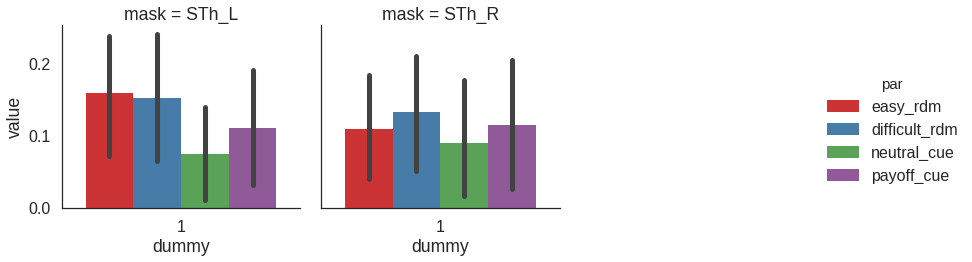

In [5]:
df_glm = pandas.DataFrame(level2_dict)
df_glm = df_glm.query('par != "constant"')
df_glm['dummy'] = 1

df_glm['% signal change'] = df_glm['value']
sns.set_palette('Set1')
sns.set_context('poster')
sns.set_style('white')

# sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95, hue_order=['payoff_cue (left)', 'payoff_cue (right)', 'neutral_cue','difficult_rdm', 'easy_rdm'])
sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95)

In [6]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')
tmp = df_glm.pivot_table(index='subject_id', values='value', columns=['par', 'mask'])

In [7]:

tmp = tmp['payoff_cue'] - tmp['neutral_cue']
shifts = shifts.merge(tmp, left_index=True, right_index=True)


In [8]:
masks = ['STh_L', 'STh_R']

{'color': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), 'marker': 'o'}
{'color': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), 'marker': 'o'}


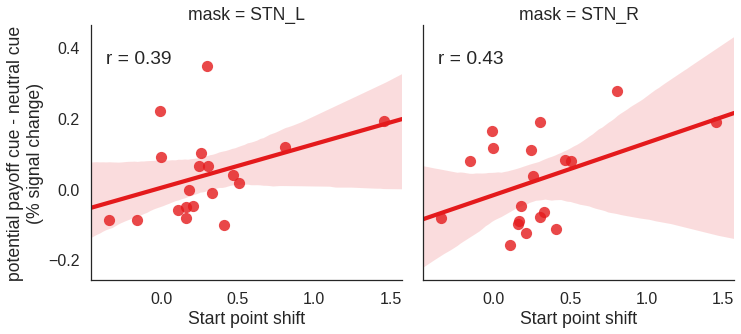

In [9]:
tmp = pandas.melt(shifts, id_vars=['v_cue_coding', 'v_difficulty', 'z_cue_coding'], var_name='mask')

tmp['mask'] = tmp['mask'].apply(lambda x: x.replace('STh', 'STN'))

# fac = sns.FacetGrid(tmp, col='mask', col_wrap=3)

# # def lmplot(x, y, color, **kwargs):
# #     sns.lmplot(x, y, **kwargs)

def make_r_title(x, y, **kwargs):
    print kwargs
    r, p = sp.stats.pearsonr(x, y)
    
    title = plt.gca().get_title()
    
    ax = plt.gca()

    y = 0.85 - len(ax.texts) * 0.05
    ax.annotate('r = %.2f' % (r), xy=(0.05,y), xycoords='axes fraction')


fac = sns.lmplot('z_cue_coding', 'value', data=tmp, col='mask', col_wrap=3)
fac.map(make_r_title, 'z_cue_coding', 'value', )
# fac.set_titles('{col_name}')
fac.set_xlabels('Start point shift')
fac.set_ylabels('potential payoff cue - neutral cue\n(% signal change)')

# plt.savefig('/home/gdholla1/projects/bias/reports/figures/startpoint_bold_interindividual.pdf')

In [10]:
import statsmodels

In [11]:
results = []

for mask in masks:
    
    shifts[mask] = (shifts[mask] - shifts[mask].mean()) / shifts[mask].std()
    
#     sns.lmplot('z_cue_coding', mask, shifts, robust=True)
    
    r, p = sp.stats.pearsonr(shifts['z_cue_coding'], shifts[mask])
#     r_, p_ = sp.stats.spearmanr(shifts['z_cue_coding'], shifts[mask])
    
    results.append({'mask':mask, 'r':r, 'p':p, })
    
results = pandas.DataFrame(results)
_, p_fdr, _, _ = statsmodels.sandbox.stats.multicomp.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results

,mask,p,r,p.fdr
0,STh_L,0.101197,0.387477,0.101197
1,STh_R,0.064020,0.433050,0.101197


In [15]:
%%R -i shifts
library(BayesFactor)

bf = regressionBF(z_cue_coding ~ 1 + STh_L, data = shifts, whichModels='all')
print(bf)
# chains_left = posterior(bf[7], iterations=100000)
# print(summary(chains_left))


bf = regressionBF(z_cue_coding ~ 1 + STh_R, data =shifts)
print(bf)
# chains_right = posterior(bf[7], iterations=100000)

# bf = lmBF(z_cue_coding ~ 1 + STh_R_B, data =shifts, iterations=10000000)
# print(bf)
# chains_right = posterior(bf[4], iterations=10000)

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_L : 1.098585 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_R : 1.460815 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS



# Model 1b



In [19]:
import itertools
import pyfir
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

level2_dict = []
adj_r = []
# pars = ['neutral_cue', 'left_cue', 'right_cue', 'neutral_easy_correct', 'valid_easy_correct', 'invalid_easy_correct', 'neutral_hard_correct', 'valid_hard_correct', 'invalid_hard_correct', 'easy_error', 'hard_error',]
# pars = 

mask = 'STh_L'

for subject_id in np.arange(1, 20):
    for run in [1,2,3]:

        try:
            onsets_dict = get_onsets(subject_id, run, 'model1b', shift=-3)
            pars = onsets_dict.keys()

            conditions = []
            onsets = []
            for key in onsets_dict.keys():
                conditions += [key] * len(onsets_dict[key])
                onsets += onsets_dict[key]

            paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                            onset=onsets,
                                                            duration=[[1.]] * len(conditions))
            tr = 3.0
            frametimes = np.linspace(0, 387 * tr, 387)
            hrf_model = 'Canonical'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=3)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)

            for i, mask in enumerate(['STh_L', 'STh_R']):
                signal = get_signal(subject_id,  run, mask)
                r = sm.GLSAR(signal, X).iterative_fit()

                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared, 'run':run})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask,
                                        'run':run})
        except Exception as e:
            print 'Error: %s/%s/%s' %  (subject_id, mask, e)

Error: 6/STh_R/all the input arrays must have same number of dimensions


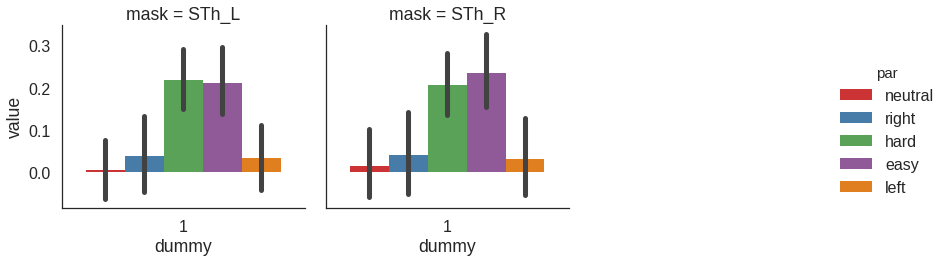

In [20]:
df_glm = pandas.DataFrame(level2_dict)
df_glm = df_glm.query('par != "constant"')
df_glm['dummy'] = 1

df_glm['% signal change'] = df_glm['value']
sns.set_palette('Set1')
sns.set_context('poster')
sns.set_style('white')

# sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95, hue_order=['payoff_cue (left)', 'payoff_cue (right)', 'neutral_cue','difficult_rdm', 'easy_rdm'])
sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95)

In [21]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')
tmp = df_glm.pivot_table(index='subject_id', values='value', columns=['par', 'mask'])
tmp = tmp['left'] - tmp['neutral']
shifts = shifts.merge(tmp, left_index=True, right_index=True)


,mask,p,r,p.fdr
0,STh_L,0.034851,0.486075,0.069702
1,STh_R,0.098906,0.389891,0.098906


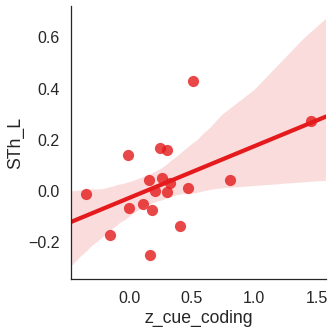

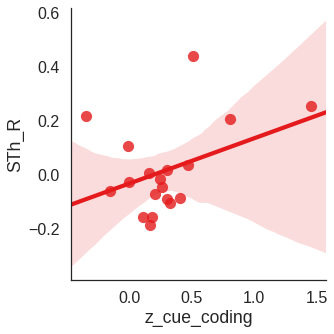

In [22]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')
tmp = df_glm.pivot_table(index='subject_id', values='value', columns=['par', 'mask'])
tmp = tmp['left'] - tmp['neutral']
shifts = shifts.merge(tmp, left_index=True, right_index=True)

results = []

for mask in masks:
    sns.lmplot('z_cue_coding', mask, shifts)
    
    r, p = sp.stats.pearsonr(shifts['z_cue_coding'], shifts[mask])
    
    results.append({'mask':mask, 'r':r, 'p':p})
    
results = pandas.DataFrame(results)
_, p_fdr, _, _ = statsmodels.sandbox.stats.multicomp.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results

In [23]:
%%R -i shifts
library(BayesFactor)

bf = regressionBF(z_cue_coding ~ 1 + STh_L, data = shifts, whichModels='all')
print(bf)

bf = regressionBF(z_cue_coding ~ 1 + STh_R, data = shifts, whichModels='all')
print(bf)

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_L : 2.174337 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_R : 1.11398 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS



# Difficulty

# Include errors

In [24]:
import itertools
import pyfir
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

level2_dict = []
adj_r = []
# pars = ['neutral_cue', 'left_cue', 'right_cue', 'neutral_easy_correct', 'valid_easy_correct', 'invalid_easy_correct', 'neutral_hard_correct', 'valid_hard_correct', 'invalid_hard_correct', 'easy_error', 'hard_error',]
# pars = 

mask = 'STh_L'

for subject_id in np.arange(1, 20):
    for run in [1,2,3]:

        try:
            onsets_dict = get_onsets(subject_id, run, 'model1a', shift=-3)
            pars = onsets_dict.keys()

            conditions = []
            onsets = []
            for key in onsets_dict.keys():
                conditions += [key] * len(onsets_dict[key])
                onsets += onsets_dict[key]

            paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                            onset=onsets,
                                                            duration=[[1.]] * len(conditions))
            tr = 3.0
            frametimes = np.linspace(0, 387 * tr, 387)
            hrf_model = 'Canonical with Derivative'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=3)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)

            for i, mask in enumerate(['STh_L', 'STh_R']):
                signal = get_signal(subject_id,  run, mask)
                r = sm.GLSAR(signal, X).iterative_fit()

                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared, 'run':run})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask,
                                        'run':run})
        except Exception as e:
            print 'Error: %s/%s/%s' %  (subject_id, mask, e)

Error: 6/STh_R/all the input arrays must have same number of dimensions


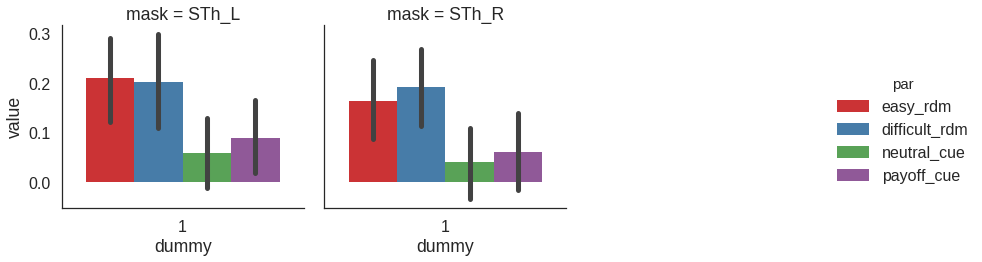

In [25]:
df_glm = pandas.DataFrame(level2_dict)
df_glm = df_glm.query('par != "constant"')
df_glm['dummy'] = 1

df_glm['% signal change'] = df_glm['value']
sns.set_palette('Set1')
sns.set_context('poster')
sns.set_style('white')

# sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95, hue_order=['payoff_cue (left)', 'payoff_cue (right)', 'neutral_cue','difficult_rdm', 'easy_rdm'])
sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95)

df_glm_include_errors = df_glm.copy()
df_glm_include_errors['include errors'] = True

In [26]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')
tmp = df_glm.pivot_table(index='subject_id', values='value', columns=['par', 'mask'])

tmp = tmp['difficult_rdm'] - tmp['easy_rdm']
shifts = shifts.merge(tmp, left_index=True, right_index=True)

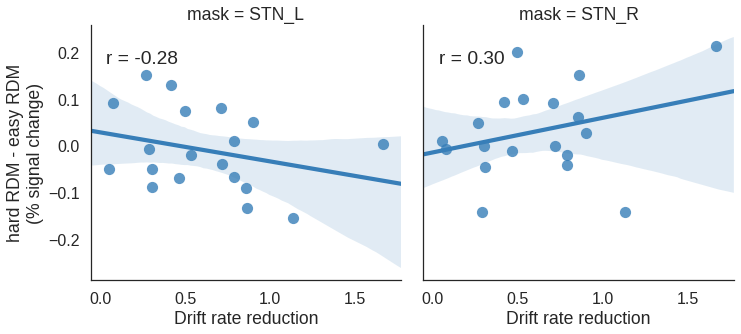

In [27]:
tmp = pandas.melt(shifts, id_vars=['v_cue_coding', 'v_difficulty', 'z_cue_coding'], var_name='mask')

tmp['mask'] = tmp['mask'].apply(lambda x: x.replace('STh', 'STN'))

# fac = sns.FacetGrid(tmp, col='mask', col_wrap=3)

# # def lmplot(x, y, color, **kwargs):
# #     sns.lmplot(x, y, **kwargs)

def make_r_title(x, y, **kwargs):
    r, p = sp.stats.pearsonr(x, y)
    
    title = plt.gca().get_title()
    
    ax = plt.gca()

    y = 0.85 - len(ax.texts) * 0.05
    ax.annotate('r = %.2f' % (r), xy=(0.05,y), xycoords='axes fraction')


sns.set_palette(sns.color_palette('Set1')[1:])

tmp['v_difficulty'] *= -1

fac = sns.lmplot('v_difficulty', 'value', data=tmp, col='mask', col_wrap=3)
fac.map(make_r_title, 'v_difficulty', 'value', )
# fac.set_titles('{col_name}')
fac.set_xlabels('Drift rate reduction')
fac.set_ylabels('hard RDM - easy RDM\n(% signal change)')


In [28]:
results = []

for mask in masks:
    r, p = sp.stats.pearsonr(shifts['v_difficulty'], shifts[mask])
    
    results.append({'mask':mask, 'r':r, 'p':p})
    
results = pandas.DataFrame(results)
_, p_fdr, _, _ = statsmodels.sandbox.stats.multicomp.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results

,mask,p,r,p.fdr
0,STh_L,0.243770,0.281058,0.24377
1,STh_R,0.212208,-0.299916,0.24377


In [41]:
%%R -i shifts
library(BayesFactor)

bf = regressionBF(v_difficulty ~ 1 + STh_L, data = shifts, whichModels='all')
print(bf)

bf = regressionBF(v_difficulty ~ 1 + STh_R, data = shifts, whichModels='all')
print(bf)

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_L : 0.9637676 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_R : 0.634818 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS



# Without errors

In [31]:
import itertools
import pyfir
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

level2_dict = []
adj_r = []
# pars = ['neutral_cue', 'left_cue', 'right_cue', 'neutral_easy_correct', 'valid_easy_correct', 'invalid_easy_correct', 'neutral_hard_correct', 'valid_hard_correct', 'invalid_hard_correct', 'easy_error', 'hard_error',]
# pars = 

mask = 'STh_L'

for subject_id in np.arange(1, 20):
    for run in [1,2,3]:

        try:
            onsets_dict = get_onsets(subject_id, run, 'model1c', shift=-3)
            pars = onsets_dict.keys()

            conditions = []
            onsets = []
            for key in onsets_dict.keys():
                conditions += [key] * len(onsets_dict[key])
                onsets += onsets_dict[key]

            paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                            onset=onsets,
                                                            duration=[[1.]] * len(conditions))
            tr = 3.0
            frametimes = np.linspace(0, 387 * tr, 387)
            hrf_model = 'Canonical with Derivative'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=3)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)

            for i, mask in enumerate(['STh_L', 'STh_R']):
                signal = get_signal(subject_id,  run, mask)
                r = sm.GLSAR(signal, X).iterative_fit()

                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared, 'run':run})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask,
                                        'run':run})
        except Exception as e:
            print 'Error: %s/%s/%s' %  (subject_id, mask, e)

Error: 6/STh_R/all the input arrays must have same number of dimensions


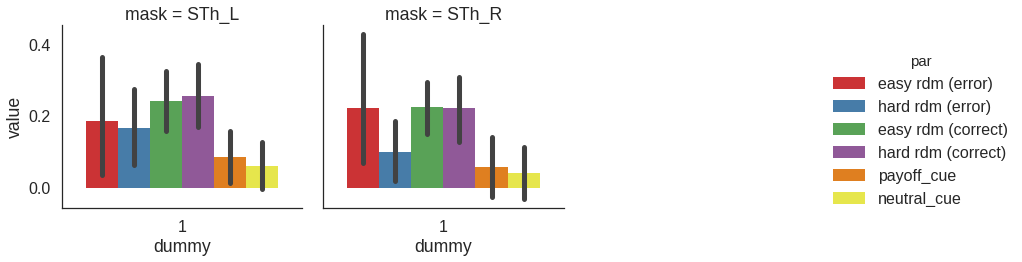

In [32]:
df_glm = pandas.DataFrame(level2_dict)
df_glm = df_glm.query('par != "constant"')
df_glm['dummy'] = 1

df_glm['% signal change'] = df_glm['value']
sns.set_palette('Set1')
sns.set_context('poster')
sns.set_style('white')

# sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95, hue_order=['payoff_cue (left)', 'payoff_cue (right)', 'neutral_cue','difficult_rdm', 'easy_rdm'])
sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95)

df_glm_no_errors = df_glm.copy()

In [33]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')
tmp = df_glm.pivot_table(index='subject_id', values='value', columns=['par', 'mask'])

tmp = tmp['hard rdm (correct)'] - tmp['easy rdm (correct)']
shifts = shifts.merge(tmp, left_index=True, right_index=True)

In [34]:
from statsmodels.sandbox.stats import multicomp

In [35]:
import statsmodels

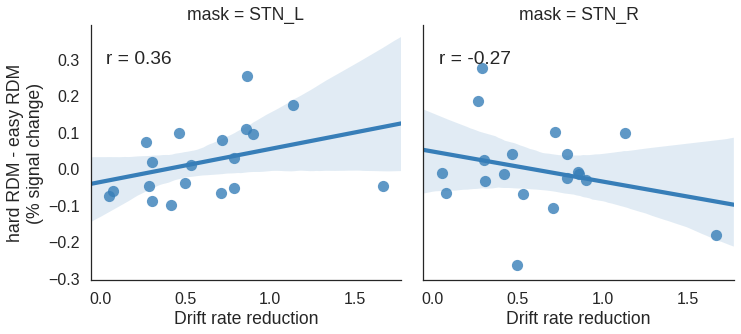

In [36]:
tmp = pandas.melt(shifts, id_vars=['v_cue_coding', 'v_difficulty', 'z_cue_coding'], var_name='mask')

tmp['mask'] = tmp['mask'].apply(lambda x: x.replace('STh', 'STN'))

# fac = sns.FacetGrid(tmp, col='mask', col_wrap=3)

# # def lmplot(x, y, color, **kwargs):
# #     sns.lmplot(x, y, **kwargs)

def make_r_title(x, y, **kwargs):
    r, p = sp.stats.pearsonr(x, y)
    
    title = plt.gca().get_title()
    
    ax = plt.gca()

    y = 0.85 - len(ax.texts) * 0.05
    ax.annotate('r = %.2f' % (r), xy=(0.05,y), xycoords='axes fraction')

tmp['v_difficulty'] *= -1

sns.set_palette(sns.color_palette('Set1')[1:])
    
fac = sns.lmplot('v_difficulty', 'value', data=tmp, col='mask', col_wrap=3)
fac.map(make_r_title, 'v_difficulty', 'value', )
# fac.set_titles('{col_name}')
fac.set_xlabels('Drift rate reduction')
fac.set_ylabels('hard RDM - easy RDM\n(% signal change)')

In [37]:
results = []

for mask in masks:
    r, p = sp.stats.pearsonr(shifts['v_difficulty'], shifts[mask])
    
    results.append({'mask':mask, 'r':r, 'p':p})
    
results = pandas.DataFrame(results)
_, p_fdr, _, _ = statsmodels.sandbox.stats.multicomp.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results

,mask,p,r,p.fdr
0,STh_L,0.125945,-0.363614,0.251889
1,STh_R,0.267729,0.267763,0.267729


In [39]:
%%R -i shifts
library(BayesFactor)

bf = regressionBF(v_difficulty ~ 1 + STh_L, data = shifts, whichModels='all')
print(bf)


bf = regressionBF(v_difficulty ~ 1 + STh_R, data = shifts, whichModels='all')
print(bf)




  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_L : 0.9637676 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_R : 0.634818 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

